# Importing Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import os
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading images from drive

In [0]:
image_path = "drive/My Drive/Colab Notebooks/dataset/train"

In [0]:
train_labels = pd.read_csv('drive/My Drive/Colab Notebooks/dataset/train.csv')

In [7]:
train_labels.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [123]:
IMAGE_SHAPE = 224
TRAINING_DATA_DIR = str(image_path)
print(TRAINING_DATA_DIR);
train_data_args = dict(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.5,
        horizontal_flip=True,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        vertical_flip=True,
        validation_split=.20)
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=.20)
valid_data = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=(IMAGE_SHAPE,IMAGE_SHAPE)
)
train_datagen = ImageDataGenerator(**train_data_args)
train_data = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=(IMAGE_SHAPE,IMAGE_SHAPE) )

drive/My Drive/Colab Notebooks/dataset/train
Found 70 images belonging to 8 classes.
Found 294 images belonging to 8 classes.


### Visualizing augmented images

In [0]:
def display_images(images_aug):
    plt.figure(figsize=(10,10))
    for n in range(len( images_aug)):
        ax = plt.subplot(2,5,n+1)
        plt.imshow(images_aug[n])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

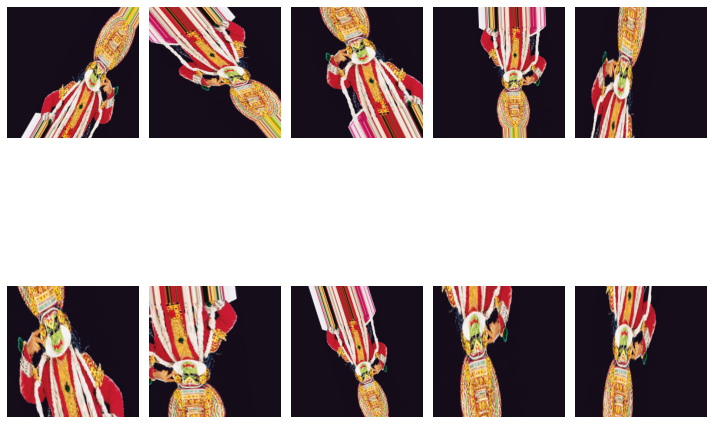

In [125]:
augmented_images = [train_data[1][0][0] for i in range(10)]
display_images(augmented_images)

#### Fetching label names for visualization

In [0]:
dataset_labels = sorted(train_data.class_indices.items())
dataset_labels = np.array([key.title() for key, value in dataset_labels])

In [127]:
dataset_labels

array(['Bharatanatyam', 'Kathak', 'Kathakali', 'Kuchipudi', 'Manipuri',
       'Mohiniyattam', 'Odissi', 'Sattriya'], dtype='<U13')

In [0]:
def display_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(dataset_labels[label_batch[n]==1][0].title())
      plt.axis('off')

###Visualization of training images of one batch

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 8)


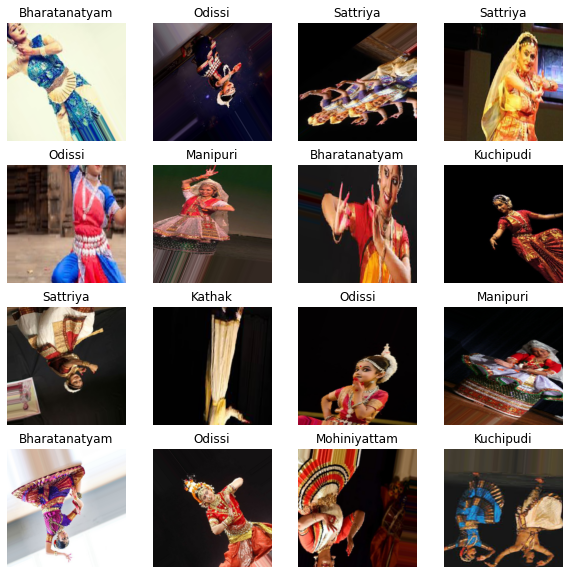

In [129]:
image_batch_train, label_batch_train = next((train_data))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
display_batch(image_batch_train, label_batch_train)

# Modelling : Loading base model MobileNetV2

In [0]:
IMG_SIZE = (IMAGE_SHAPE,IMAGE_SHAPE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE,
                                               include_top=False,
                                               weights='imagenet')

In [0]:
base_model.trainable = False

In [0]:
global_average_layer = keras.layers.GlobalAveragePooling2D()


In [0]:
prediction_layer = keras.layers.Dense(train_data.num_classes, activation='softmax')


In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [149]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 10248     
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
      # recall = TP/ (TP + FN)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (total_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
      # precision = TP/ (TP + FP)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
base_learning_rate = 0.001   #tf.keras.optimizers.RMSprop(lr=base_learning_rate
model.compile(optimizer= 'adam' ,
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])

In [0]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)
val_steps_per_epoch = np.ceil(valid_data.samples/valid_data.batch_size)

In [0]:
early_stopping = keras.callbacks.EarlyStopping(patience= 10, monitor= 'val_loss', restore_best_weights= True)

In [154]:
history = model.fit(train_data,validation_data= valid_data, steps_per_epoch= steps_per_epoch , validation_steps= val_steps_per_epoch, epochs= 40, callbacks=[early_stopping])

Epoch 1/40
10/10 [==============================] - 16s 2s/step - loss: 2.5031 - accuracy: 0.1463 - f1: 0.0276 - val_loss: 2.2338 - val_accuracy: 0.1000 - val_f1: 0.0370
Epoch 2/40
10/10 [==============================] - 15s 1s/step - loss: 2.0483 - accuracy: 0.2075 - f1: 0.0596 - val_loss: 2.0018 - val_accuracy: 0.2429 - val_f1: 0.1216
Epoch 3/40
10/10 [==============================] - 15s 2s/step - loss: 1.7604 - accuracy: 0.3503 - f1: 0.1700 - val_loss: 1.7548 - val_accuracy: 0.2857 - val_f1: 0.2238
Epoch 4/40
10/10 [==============================] - 15s 1s/step - loss: 1.5380 - accuracy: 0.4626 - f1: 0.2994 - val_loss: 1.6107 - val_accuracy: 0.3571 - val_f1: 0.1903
Epoch 5/40
10/10 [==============================] - 15s 1s/step - loss: 1.4707 - accuracy: 0.4558 - f1: 0.2885 - val_loss: 1.4824 - val_accuracy: 0.4286 - val_f1: 0.3535
Epoch 6/40
10/10 [==============================] - 15s 1s/step - loss: 1.3167 - accuracy: 0.5238 - f1: 0.3632 - val_loss: 1.3987 - val_accuracy: 0.50

### visualization of loss and accuracy of training and validation data

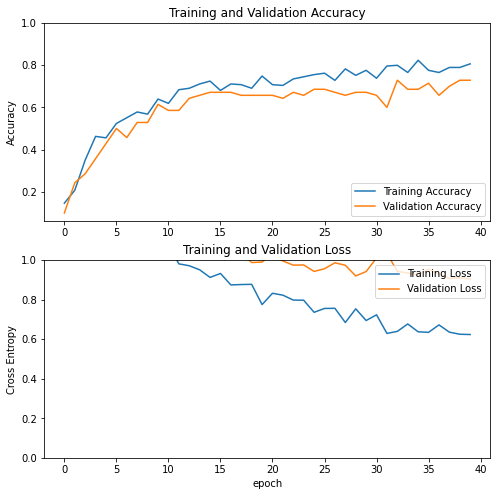

In [159]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning the model by training the last few layers of MobileNetV2

In [0]:
base_model.trainable = True

In [161]:
print(len(base_model.layers))

155


In [0]:
for layer in base_model.layers[:100]:
  layer.trainable = False



In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy',f1])

In [165]:
history_fine = model.fit(train_data, validation_data = valid_data, steps_per_epoch= steps_per_epoch, validation_steps=val_steps_per_epoch, initial_epoch= history.epoch[-1], epochs = 55, callbacks=[early_stopping])

Epoch 40/55
10/10 [==============================] - 23s 2s/step - loss: 0.8511 - accuracy: 0.7109 - f1: 0.6053 - val_loss: 0.8295 - val_accuracy: 0.7429 - val_f1: 0.7421
Epoch 41/55
10/10 [==============================] - 22s 2s/step - loss: 0.7229 - accuracy: 0.7585 - f1: 0.7275 - val_loss: 0.7755 - val_accuracy: 0.6857 - val_f1: 0.6530
Epoch 42/55
10/10 [==============================] - 23s 2s/step - loss: 0.6515 - accuracy: 0.7653 - f1: 0.7629 - val_loss: 0.7249 - val_accuracy: 0.7714 - val_f1: 0.6881
Epoch 43/55
10/10 [==============================] - 23s 2s/step - loss: 0.5556 - accuracy: 0.7925 - f1: 0.7680 - val_loss: 0.8238 - val_accuracy: 0.7429 - val_f1: 0.6898
Epoch 44/55
10/10 [==============================] - 22s 2s/step - loss: 0.5416 - accuracy: 0.8367 - f1: 0.7729 - val_loss: 0.8161 - val_accuracy: 0.7286 - val_f1: 0.6707
Epoch 45/55
10/10 [==============================] - 23s 2s/step - loss: 0.4965 - accuracy: 0.8537 - f1: 0.8323 - val_loss: 0.6648 - val_accuracy

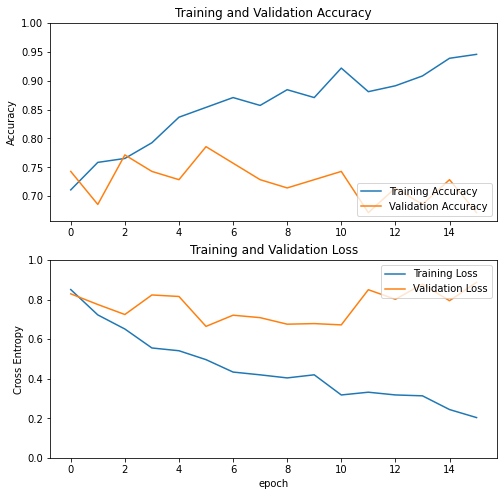

In [166]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [121]:
val_batch_data, val_batch_label = next(valid_data)
model_predictions = model.predict(val_batch_data)
print('Prediction results shape:', model_predictions.shape)


Prediction results shape: (6, 8)


### Visualizing the performance of model on validation data

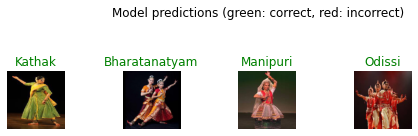

In [122]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((model_predictions.shape[0])-2):
 plt.subplot(6,5,n+1)
 plt.imshow(val_batch_data[n])
 color = 'green' if np.argmax(model_predictions[n]) == np.argmax(val_batch_label[n]) else 'red'
 plt.title(dataset_labels[np.argmax(model_predictions[n])], color=color)
 plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

### Model prediction for test set 

In [0]:
test_imgs = pd.read_csv('drive/My Drive/Colab Notebooks/dataset/test.csv')

In [0]:
test_image_path = 'drive/My Drive/Colab Notebooks/dataset/test'

In [210]:

IMAGE_SHAPE = 224
TEST_DATA_DIR = str(test_image_path)
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
TEST_DATA_DIR,
batch_size = len(test_imgs),
shuffle = False,
target_size=(IMAGE_SHAPE,IMAGE_SHAPE)
)


Found 156 images belonging to 1 classes.


In [222]:
dataset_labels[np.argmax(model.predict(tf.expand_dims(test_data[0][0][4], 0)))]

'Odissi'

In [0]:
model_pred = model.predict(test_data)

In [216]:
prediction = pd.DataFrame(test_data.filenames, columns = ['Image'])
prediction['target'] = 0
for i in range(len(model_pred)):
  prediction['target'][i] = dataset_labels[np.argmax(model_pred[i])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [225]:
prediction.head()

,Image,target
0,108.jpg,Manipuri
1,11.jpg,Kathak
2,110.jpg,Manipuri
3,112.jpg,Bharatanatyam
4,114.jpg,Odissi


In [0]:
prediction['Image'] = [prediction['Image'][i].split('/')[1] for i in range(len(prediction['Image']))]

In [0]:
result = pd.merge(test_imgs,prediction,how= 'inner', on = 'Image')

In [0]:
from google.colab import files
result.to_csv("output.csv")
files.download('output.csv')